**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# TabNet

We import the libraries and define constants and settings of the notebook:

In [32]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.augmentations import ClassificationSMOTE
from sklearn.model_selection import train_test_split
import os, sys
sys.path.append(os.path.abspath('../TASK_3/'))
from classification_utils import *
from time import time
from explanation_utils import *
RESULTS_DIR = '../data/classification_results'
clf_name = 'TabNetClassifier'

We load the data:

In [33]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_scaled_indicators_test.csv', index_col=0)

true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_distance_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

# scale the data
scaler = MinMaxScaler()
indicators_train_scaled = scaler.fit_transform(indicators_train_df)
# split the data into train and validation sets
train_set, val_set, train_labels, val_labels = train_test_split(
    indicators_train_scaled,
    true_labels_train,
    test_size=0.2
)

In [34]:
tabnet = TabNetClassifier()
fit_start = time()
tabnet.fit(
  train_set, train_labels,
  eval_set=[(train_set, train_labels), (val_set, val_labels)],
  eval_name=['train', 'val'],
  eval_metric=['balanced_accuracy', 'logloss'],
  max_epochs=200
)
fit_time = time()-fit_start

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60278 | train_balanced_accuracy: 0.50145 | train_logloss: 0.5914  | val_balanced_accuracy: 0.5015  | val_logloss: 0.59612 |  0:00:08s
epoch 1  | loss: 0.53928 | train_balanced_accuracy: 0.59252 | train_logloss: 0.58453 | val_balanced_accuracy: 0.59582 | val_logloss: 0.58827 |  0:00:16s
epoch 2  | loss: 0.52734 | train_balanced_accuracy: 0.6615  | train_logloss: 0.59247 | val_balanced_accuracy: 0.66003 | val_logloss: 0.59406 |  0:00:25s
epoch 3  | loss: 0.52207 | train_balanced_accuracy: 0.64728 | train_logloss: 0.54868 | val_balanced_accuracy: 0.64779 | val_logloss: 0.5519  |  0:00:33s
epoch 4  | loss: 0.51624 | train_balanced_accuracy: 0.68151 | train_logloss: 0.54194 | val_balanced_accuracy: 0.67423 | val_logloss: 0.5465  |  0:00:42s
epoch 5  | loss: 0.51263 | train_balanced_accuracy: 0.685   | train_logloss: 0.53222 | val_balanced_accuracy: 0.67955 | val_logloss: 0.53806 |  0:00:50s
epoch 6  | loss: 0.51124 | train_balanced_accuracy: 0.68077 | train_logloss: 0.528

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


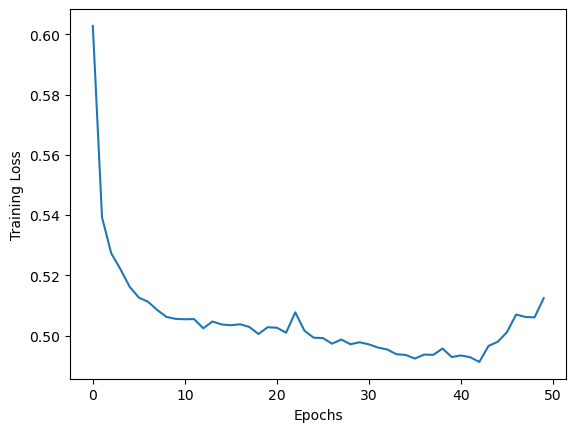

In [35]:
plt.plot(tabnet.history['loss'], label='Train')
plt.xlabel('Epochs');
plt.ylabel('Training Loss');

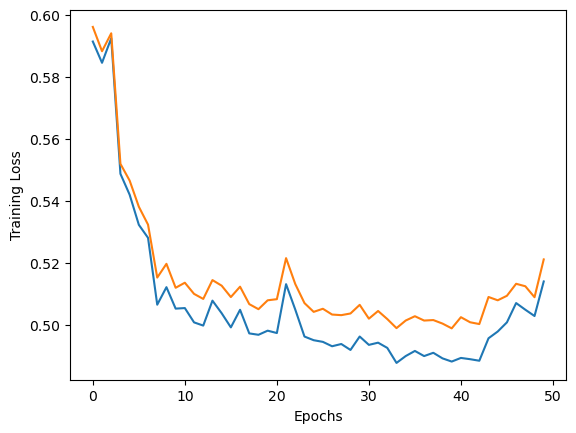

In [36]:
plt.plot(tabnet.history['train_logloss'], label='Train')
plt.plot(tabnet.history['val_logloss'], label='Validation')
plt.xlabel('Epochs');
plt.ylabel('Training Loss');

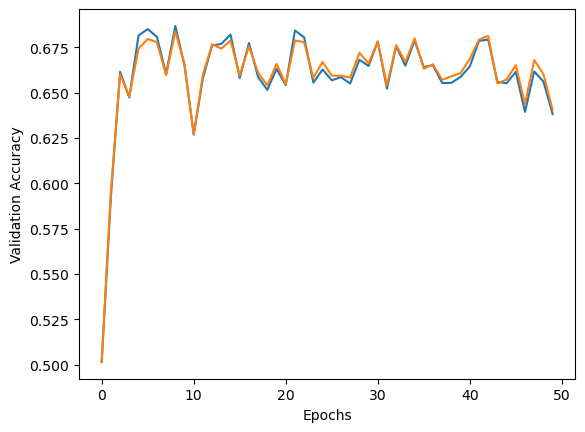

In [37]:
plt.plot(tabnet.history['train_balanced_accuracy'], label='Train')
plt.plot(tabnet.history['val_balanced_accuracy'], label='Validation')
plt.xlabel('Epochs');
plt.ylabel('Validation Accuracy');

In [38]:
# get the predictions on the training data
train_score_start = time()
pred_labels_train = tabnet.predict(indicators_train_scaled)
train_score_time = time()-train_score_start
pred_probas_train = tabnet.predict_proba(indicators_train_scaled)

# get the predictions on the test data
test_score_start = time()
pred_labels_test = tabnet.predict(indicators_test_df.values)
test_score_time = time()-test_score_start
pred_probas_test = tabnet.predict_proba(indicators_test_df.values)

# save the predictions
pd.DataFrame(
   {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the model
tabnet.save_model(f'{RESULTS_DIR}/{clf_name}.pkl')

Successfully saved model at ../data/classification_results/TabNetClassifier.pkl.zip


'../data/classification_results/TabNetClassifier.pkl.zip'

In [39]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=tabnet.get_params(),
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
TabNetClassifier,0.764472,0.920381,0.835213,0.701728,0.397799,0.507758,0.7331,0.65909,0.671485,0.744385,0.753085,0.730383,0.753085,0.799792,420.67114,1.803513,"{'cat_dims': [], 'cat_emb_dim': [], 'cat_idxs'..."


In [40]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=tabnet.get_params(),
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
TabNetClassifier,0.763325,0.920516,0.834583,0.699975,0.393838,0.504066,0.73165,0.657177,0.669325,0.743045,0.751915,0.728777,0.751915,0.794833,420.67114,0.8585,"{'cat_dims': [], 'cat_emb_dim': [], 'cat_idxs'..."


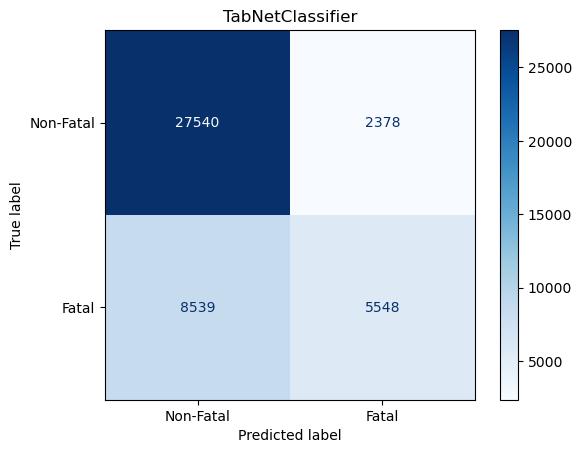

In [41]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    title=clf_name
)

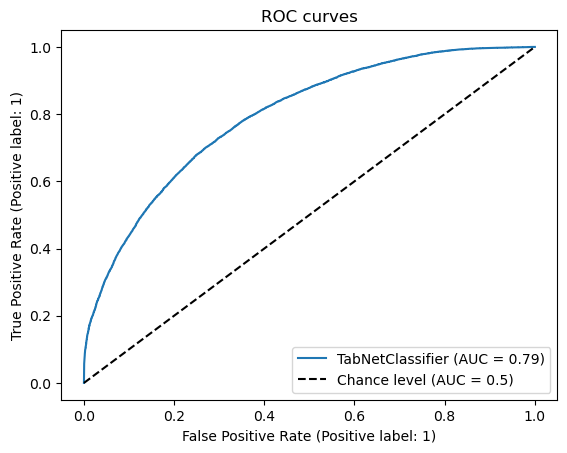

In [42]:
plot_roc(y_true=true_labels_test, y_probs=[pred_probas_test[:,1]], names=[clf_name])

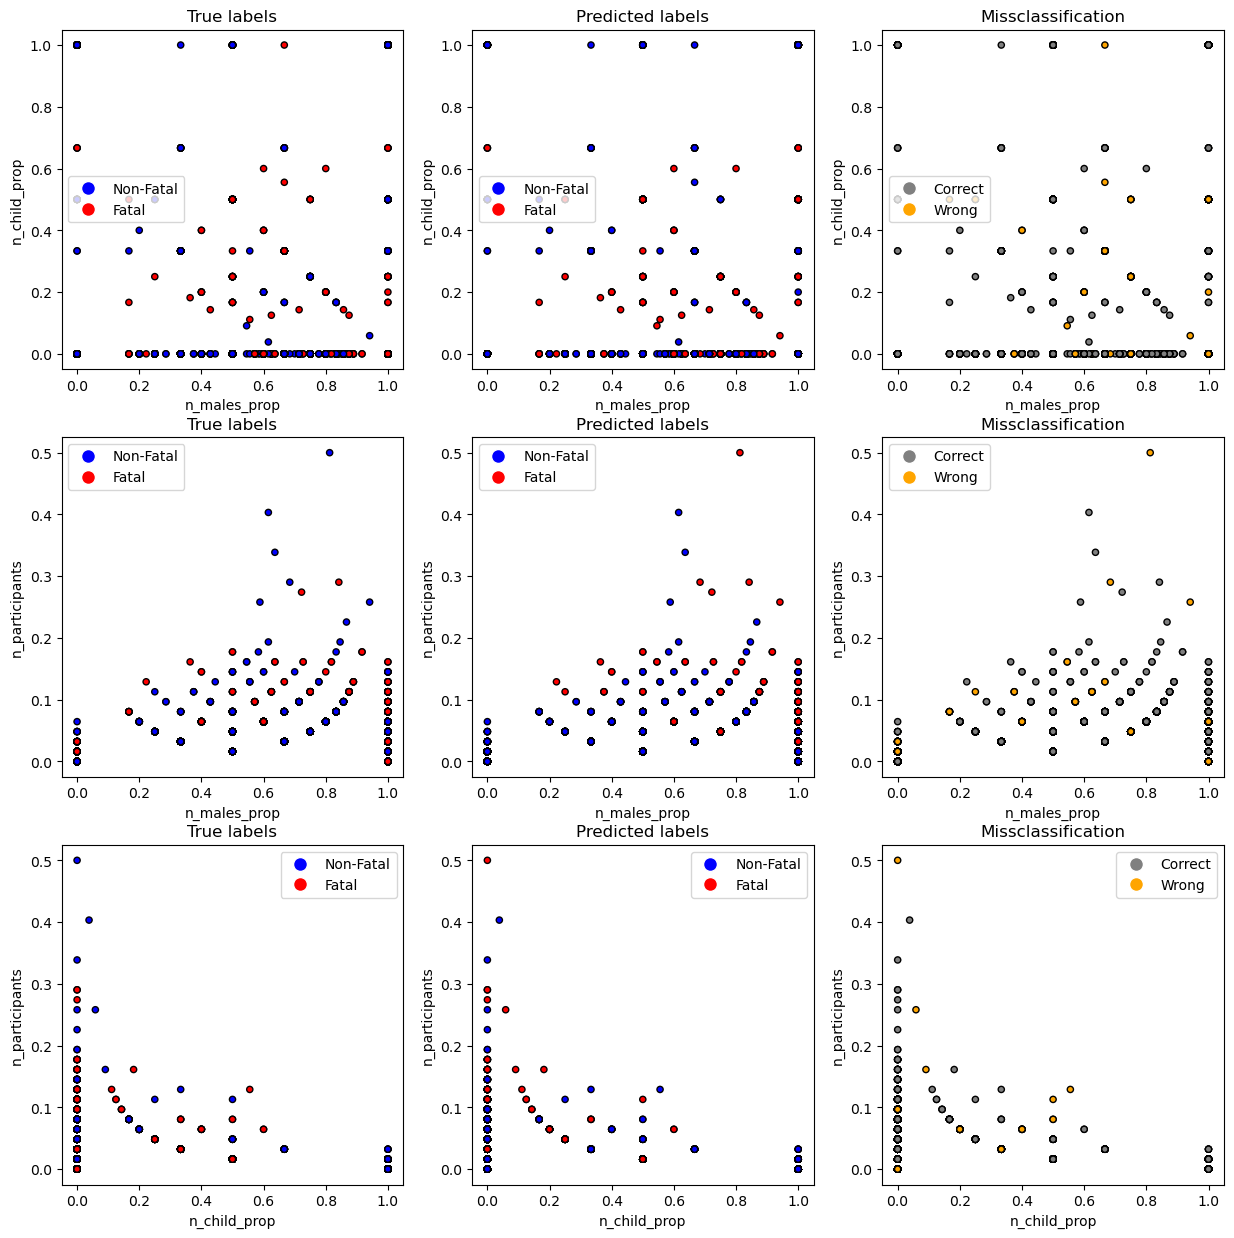

In [43]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['n_males_prop', 'n_child_prop', 'n_participants'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_test,
    figsize=(15, 15)
)

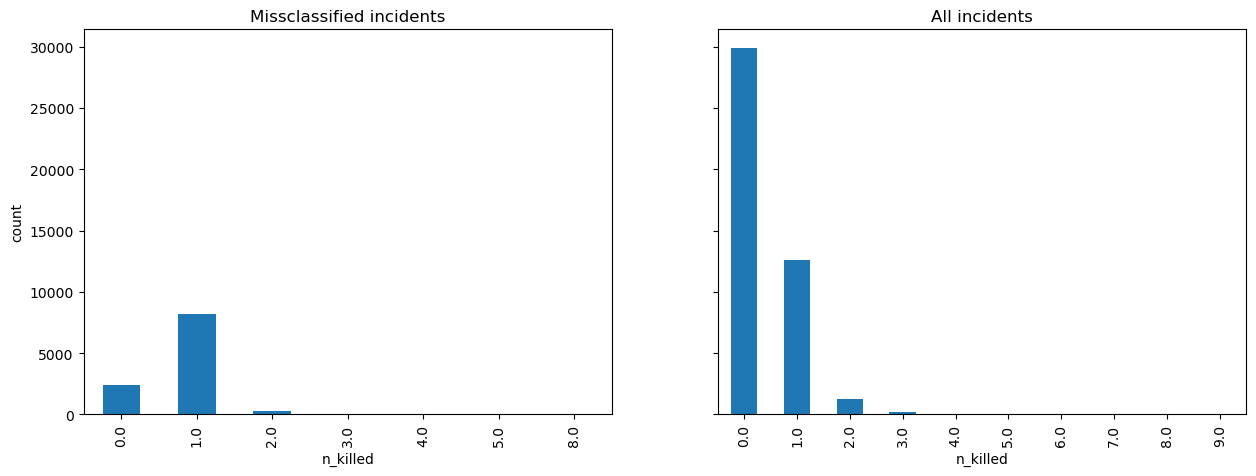

In [44]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'n_killed',
    'bar'
)

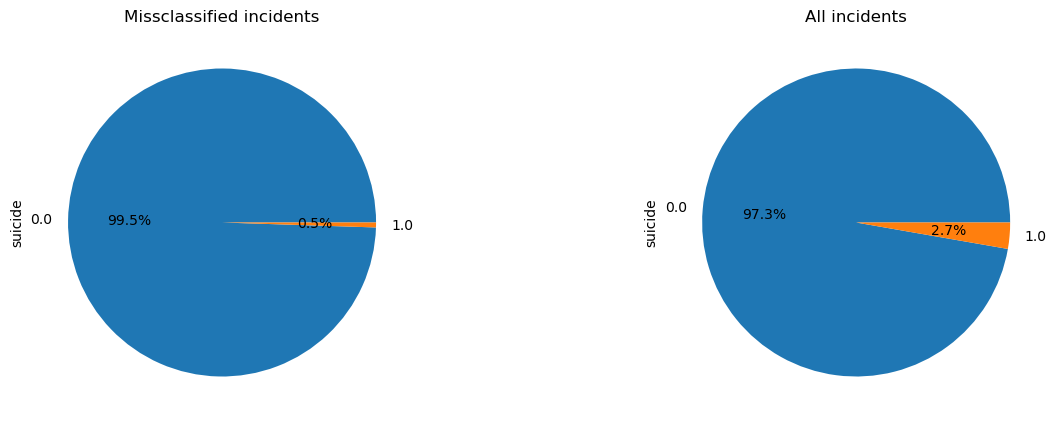

In [45]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'suicide',
    'pie'
)

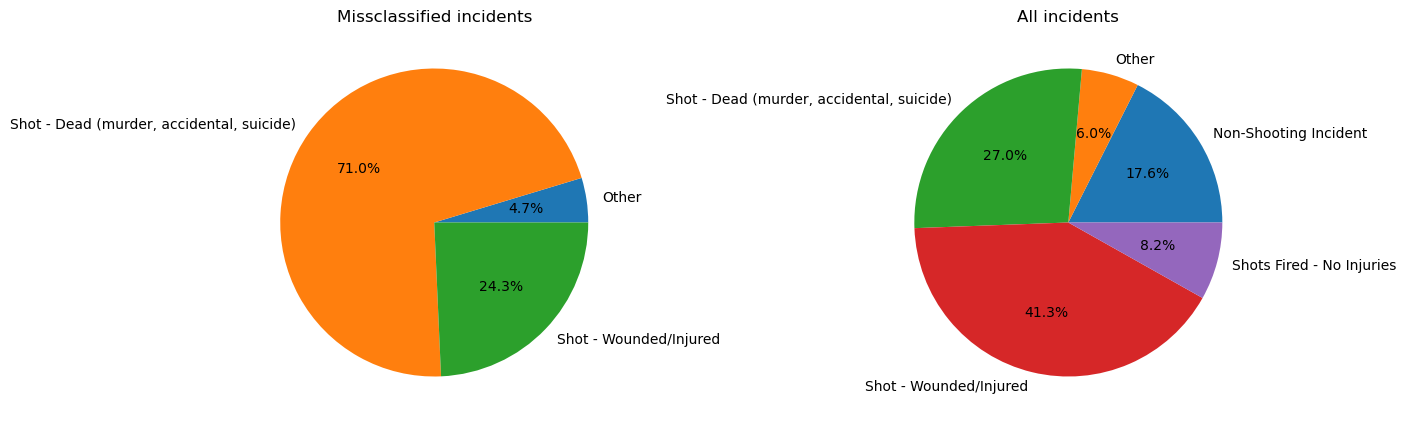

In [46]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics1',
    'pie'
)

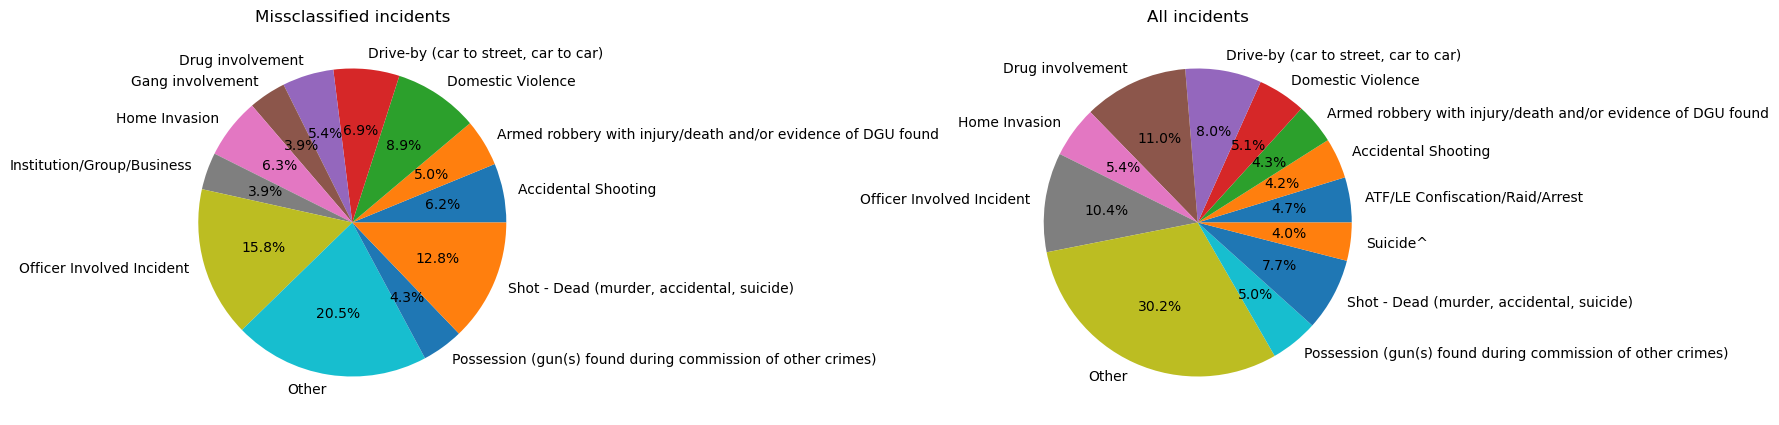

In [47]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics2',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5)
)

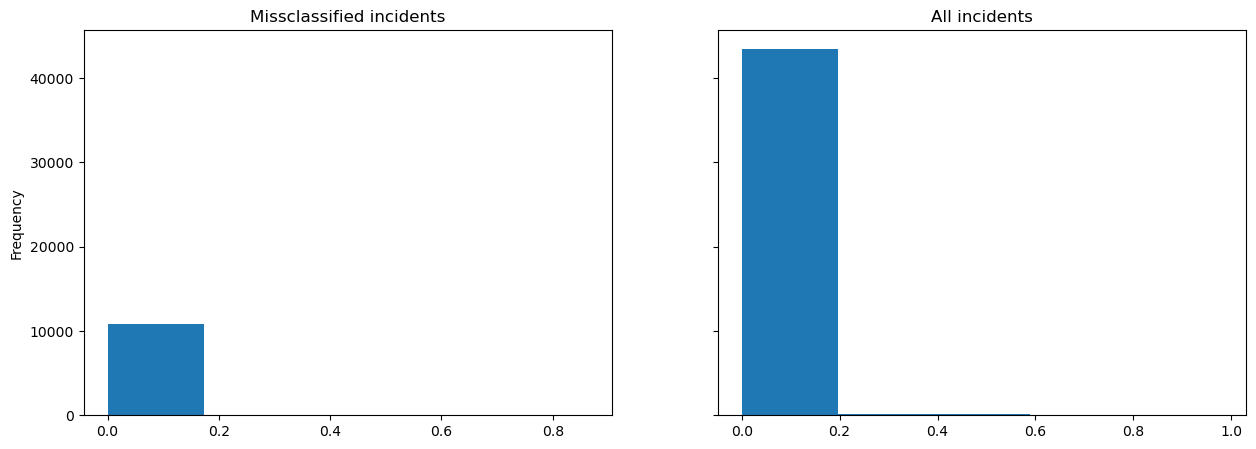

In [48]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5
)

## Global interpretation

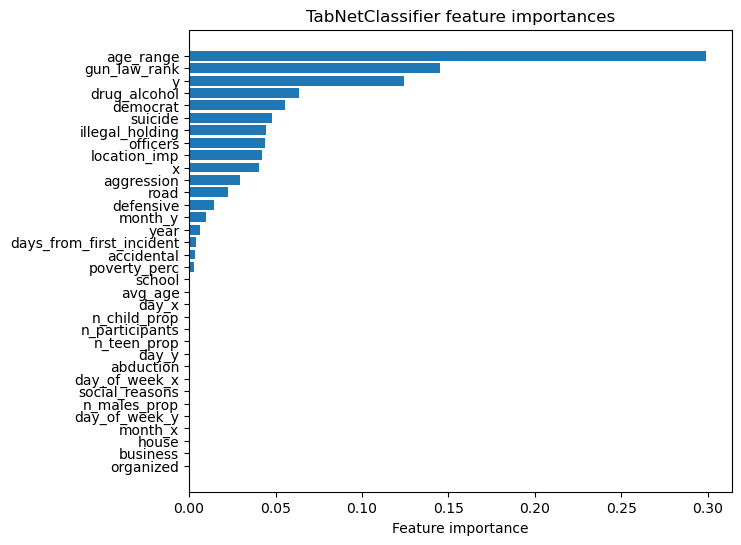

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(7,6))
display_feature_importances(
    features_for_clf,
    tabnet.feature_importances_,
    axs,
    title='TabNetClassifier feature importances',
    path=f'{RESULTS_DIR}/{clf_name}_feature_importances.csv'
)

# Local interpretation

## Attempted Suicide

In [50]:
selected_records_to_explain_df = pd.read_csv('../data/explanation_results/selected_records_to_explain.csv', index_col=0)
attempted_suicide_pos = selected_records_to_explain_df[selected_records_to_explain_df['instance names']=='Attempted Suicide']['positions'][0]

In [51]:
explanation, mask = tabnet.explain(indicators_test_df.iloc[attempted_suicide_pos].values.reshape(1,-1), normalize=False)
prediction = tabnet.predict(indicators_test_df.iloc[attempted_suicide_pos].values.reshape(1,-1))

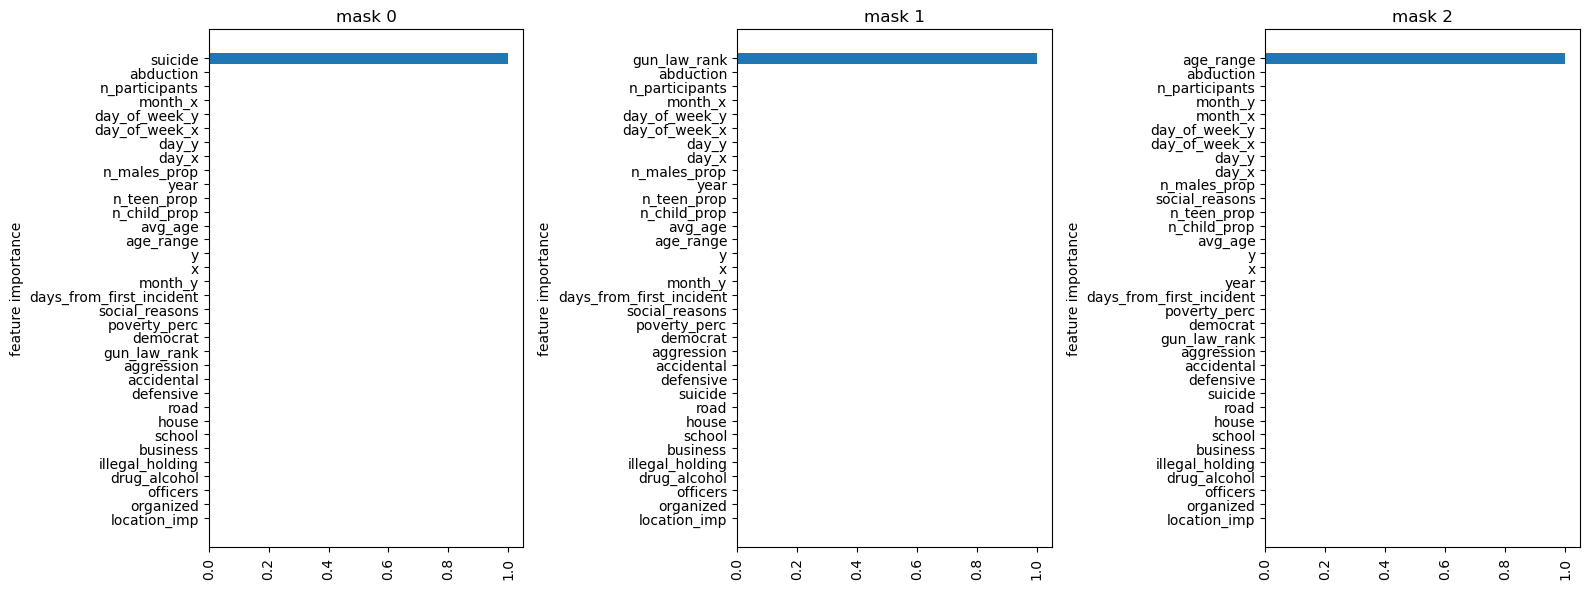

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharex=True)
mask_sum = np.zeros_like(mask[0][0])
for i in range(3):
    mask_sum += mask[i][0]
    sorted_idx = np.argsort(mask[i][0])
    sorted_features_names = [features_for_clf[j] for j in sorted_idx]
    sorted_features_imp = [mask[i][0][j] for j in sorted_idx]
    axs[i].barh(y=sorted_features_names, width=sorted_features_imp)
    axs[i].set_title(f"mask {i}")
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90);
    axs[i].set_ylabel('feature importance')
fig.tight_layout()

Text(0.5, 0, 'feature importance (mask 1 + mask 2 + mask 3)')

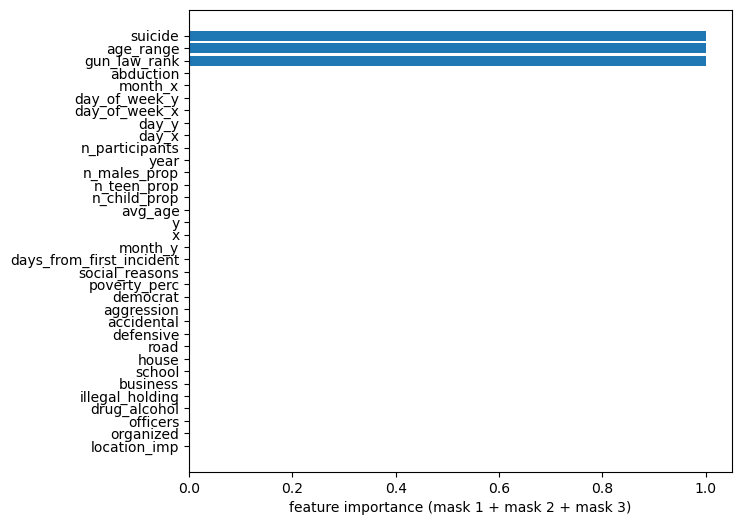

In [53]:
fig, axs = plt.subplots(1, figsize=(7, 6))
sorted_idx = np.argsort(mask_sum)
sorted_features_names = [features_for_clf[j] for j in sorted_idx]
sorted_features_imp = [mask_sum[j] for j in sorted_idx]
plt.barh(y=sorted_features_names, width=sorted_features_imp)
axs.set_xlabel('feature importance (mask 1 + mask 2 + mask 3)')

Text(0.5, 1.0, "TabNet's local explanation for a suicide attempt (prediction=1)")

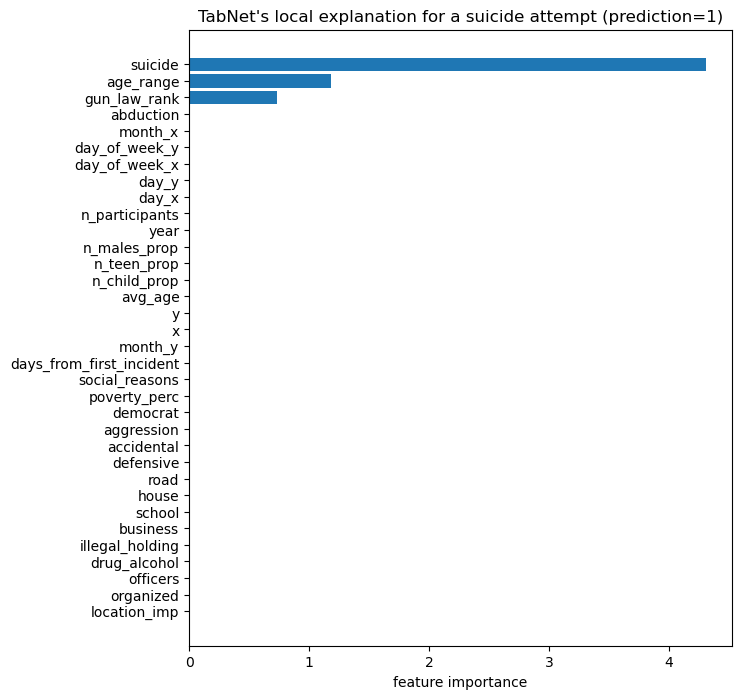

In [54]:
sorted_idx = np.argsort(explanation[0])
sorted_features_names = [features_for_clf[j] for j in sorted_idx]
sorted_features_imp = [explanation[0][j] for j in sorted_idx]
fig, axs = plt.subplots(1, figsize=(7, 8))
axs.barh(y=sorted_features_names, width=sorted_features_imp)
axs.set_xlabel('feature importance (explanation)')
axs.set_xlabel('feature importance')
axs.set_title(f"TabNet's local explanation for a suicide attempt (prediction={prediction[0]})")

## Mass shooting

In [55]:
mass_shooting_pos = selected_records_to_explain_df[selected_records_to_explain_df['instance names']=='Mass shooting']['positions']

In [56]:
explanation, mask = tabnet.explain(indicators_test_df.iloc[mass_shooting_pos].values.reshape(1,-1), normalize=False)
prediction = tabnet.predict(indicators_test_df.iloc[mass_shooting_pos].values.reshape(1,-1))

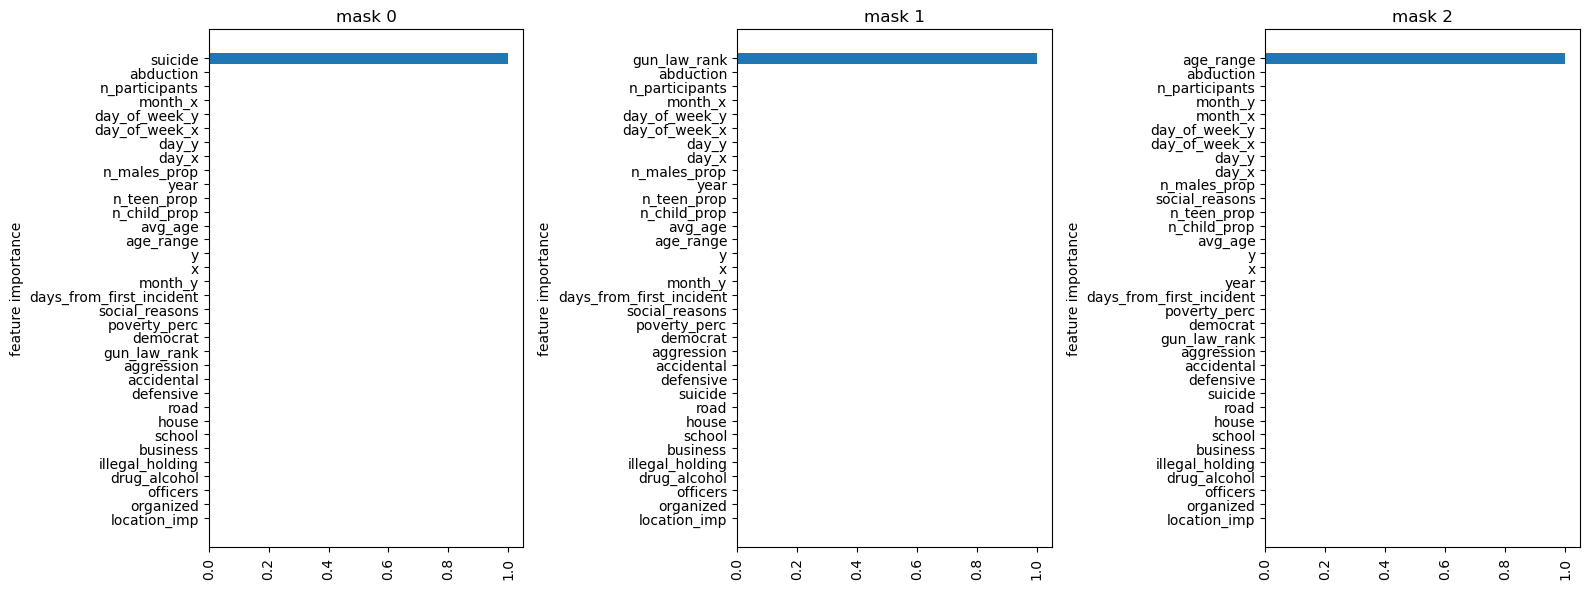

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharex=True)
mask_sum = np.zeros_like(mask[0][0])
for i in range(3):
    mask_sum += mask[i][0]
    sorted_idx = np.argsort(mask[i][0])
    sorted_features_names = [features_for_clf[j] for j in sorted_idx]
    sorted_features_imp = [mask[i][0][j] for j in sorted_idx]
    axs[i].barh(y=sorted_features_names, width=sorted_features_imp)
    axs[i].set_title(f"mask {i}")
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90);
    axs[i].set_ylabel('feature importance')
fig.tight_layout()

Text(0.5, 0, 'feature importance (mask 1 + mask 2 + mask 3)')

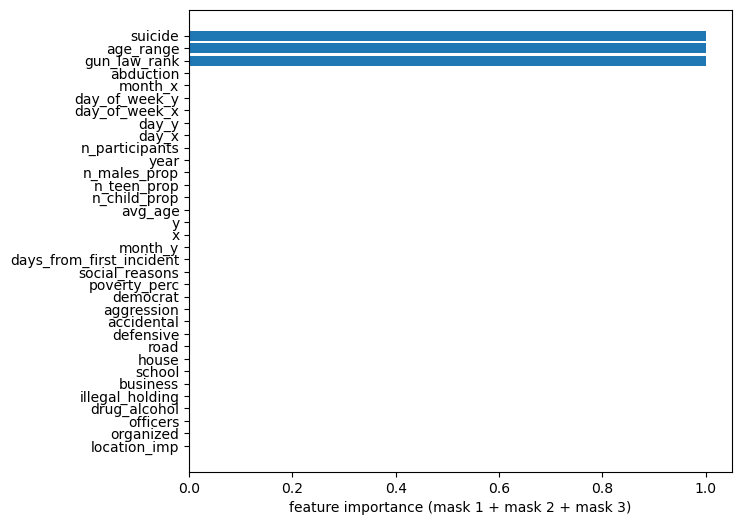

In [58]:
fig, axs = plt.subplots(1, figsize=(7, 6))
sorted_idx = np.argsort(mask_sum)
sorted_features_names = [features_for_clf[j] for j in sorted_idx]
sorted_features_imp = [mask_sum[j] for j in sorted_idx]
plt.barh(y=sorted_features_names, width=sorted_features_imp)
axs.set_xlabel('feature importance (mask 1 + mask 2 + mask 3)')

Text(0.5, 1.0, "TabNet's local explanation for a mass shooting (prediction=1)")

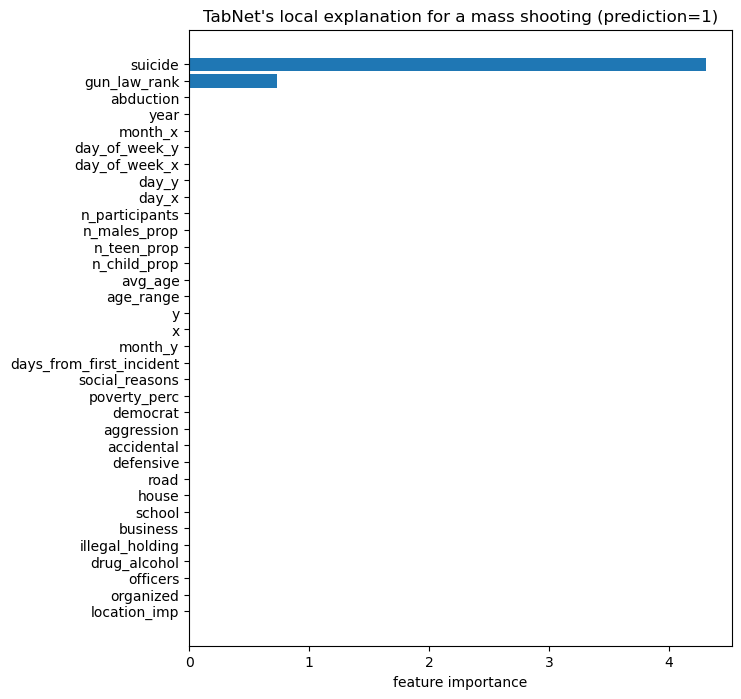

In [59]:
sorted_idx = np.argsort(explanation[0])
sorted_features_names = [features_for_clf[j] for j in sorted_idx]
sorted_features_imp = [explanation[0][j] for j in sorted_idx]
fig, axs = plt.subplots(1, figsize=(7, 8))
axs.barh(y=sorted_features_names, width=sorted_features_imp)
axs.set_xlabel('feature importance')
axs.set_title(f"TabNet's local explanation for a mass shooting (prediction={prediction[0]})")

# Evaluation of explanations

In [60]:
non_fatal_default = pd.read_csv(RESULTS_DIR+'/non_fatal_db_default_features.csv').to_numpy()[0]
fatal_default = pd.read_csv(RESULTS_DIR+'/fatal_db_default_features.csv').to_numpy()[0]

In [61]:
positions_to_explain = selected_records_to_explain_df['positions'].to_list()
instance_names_to_explain = selected_records_to_explain_df['instance names'].to_list()
true_labels_to_explain = selected_records_to_explain_df['true labels'].to_list()

instances = indicators_test_df.iloc[positions_to_explain].values
metrics_selected_records = {}
for i in range(instances.shape[0]):
    prediction = tabnet.predict(instances[i].reshape(1,-1))
    feature_importances, _ = tabnet.explain(instances[i].reshape(1,-1), normalize=False)
    feature_default = non_fatal_default if true_labels_test[i] == 1 else fatal_default
    sample_metric = evaluate_explanation(tabnet, instances[i], feature_importances, feature_default)
    metrics_selected_records[instance_names_to_explain[i]] = sample_metric

metrics_selected_records_df = pd.DataFrame(metrics_selected_records).T
metrics_selected_records_df.to_csv('../data/explanation_results/tabnet_metrics_selected_records.csv')
metrics_selected_records_df

,faithfulness,monotonicity
Attempted Suicide,0.148331,False
Mass shooting,0.086702,False
Fatal with highest confidence by DecisionTreeClassifier,0.201583,True
Fatal with highest confidence by NeuralNetworkClassifier,0.086702,False
Fatal with highest confidence by RandomForestClassifier,0.22164,False
Fatal with highest confidence by NaiveBayesMixedClassifier,0.285708,False
Fatal with highest confidence by SupportVectorMachineClassifier,-0.087786,False
Fatal with highest confidence by TabNetClassifier,0.237841,False
Fatal with highest confidence by ExtremeGradientBoostingClassifier,0.046187,False
Non-Fatal with highest confidence by DecisionTreeClassifier,0.648948,True


In [62]:
random_records_to_explain_df = pd.read_csv('../data/explanation_results/random_records_to_explain.csv', index_col=0)
positions_to_explain = random_records_to_explain_df['positions'].to_list()
true_labels_to_explain = random_records_to_explain_df['true labels'].to_list()

instances = indicators_test_df.iloc[positions_to_explain].values
faithfulness = []
for i in range(instances.shape[0]):
    prediction = tabnet.predict(instances[i].reshape(1,-1))
    feature_importances, _ = tabnet.explain(instances[i].reshape(1,-1), normalize=False)
    feature_default = non_fatal_default if true_labels_test[i] == 1 else fatal_default
    sample_metric = evaluate_explanation(tabnet, instances[i], feature_importances, feature_default)
    faithfulness.append(sample_metric['faithfulness'])

metrics_random_records = {}
metrics_random_records['mean faithfulness'] = np.nanmean(faithfulness)
metrics_random_records['std faithfulness'] = np.nanstd(faithfulness)
metrics_random_records_df = pd.DataFrame(metrics_random_records, index=[clf_name])
metrics_random_records_df.to_csv('../data/explanation_results/tabnet_metrics_random_records.csv')
metrics_random_records_df

,mean faithfulness,std faithfulness
TabNetClassifier,0.165121,0.192939
